# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline as skPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# Read data into DFs

In [2]:
# 1. Column names (15 features + label)
headers = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'pred'   # label (<=50K / >50K)
]

# 2. Read raw data
original_train_df = pd.read_csv(
    "census-income.data.csv",
    header=None,
    names=headers,
    index_col=False
)

original_test_df = pd.read_csv(
    "census-income.test.csv",
    header=None,
    names=headers,
    index_col=False
)

# Work on copies
train_df = original_train_df.copy()
test_df = original_test_df.copy()

In [3]:
# Transform target into binary

target_map = {
'<=50K': 0,
'>50K': 1,
'<=50K.': 0,
'>50K.': 1
}

train_df['pred'] = train_df['pred'].str.strip().map(target_map)
test_df['pred'] = test_df['pred'].str.strip().map(target_map)

In [4]:
# ---------- Helper Functions ----------

def data_to_str(df):
    """Strip leading/trailing spaces from all object columns."""
    df = df.copy()
    str_cols = df.select_dtypes(include=["object"]).columns
    for col in str_cols:
        df[col] = df[col].str.strip()
    return df

def replace_qmarks(df):
    """Convert '?' to np.nan."""
    return df.replace("?", np.nan)


def category_remapping(df):
    '''Maps categorical variables into more functional bins'''
    copy_df = df.copy()
    
    # workclass
    workclass_mapping = {
        'State-gov':'Government',
        'Local-gov':'Government',
        'Federal-gov':'Government',
        'Self-emp-inc':'Incorporated-Entrepreneur',
        'Self-emp-not-inc':'Unincorporated-Entrepreneur',
        'Without-pay':'Unemployed',
        'Never-worked':'Unemployed',
        'Private':'Private'
    }
    if "workclass" in copy_df:
        copy_df["workclass-cat"] = copy_df["workclass"].map(workclass_mapping)
    
    # education
    edu_mapping = {
        'Preschool':'HS-dropout',
        '1st-4th':'HS-dropout',
        '5th-6th':'HS-dropout',
        '7th-8th':'HS-dropout',
        '9th':'HS-dropout',
        '10th':'HS-dropout',
        '11th':'HS-dropout',
        '12th':'HS-dropout',
        'HS-grad':'HS-grad',
        'Some-college':'Some-college',
        'Assoc-acdm':'Some-college',
        'Assoc-voc':'Some-college',
        'Bachelors':'Bachelors',
        'Masters':'Advanced-degree',
        'Prof-school':'Advanced-degree',
        'Doctorate':'Advanced-degree'
    }
    if "education" in copy_df:
        copy_df["education-cat"] = copy_df["education"].map(edu_mapping)
    
    # marital-status
    marital_mapping = {
        'Never-married':'Single/Unmarried',
        'Divorced':'Single/Unmarried',
        'Separated':'Single/Unmarried',
        'Widowed':'Single/Unmarried',
        'Married-spouse-absent':'Single/Unmarried',
        'Married-civ-spouse':'Married',
        'Married-AF-spouse':'Married'
    }
    if "marital-status" in copy_df:
        copy_df["marital-cat"] = copy_df["marital-status"].map(marital_mapping)
    
    # occupation
    occupation_mapping = {
        'Exec-managerial':'White-collar',
        'Prof-specialty':'White-collar',
        'Tech-support':'White-collar',
        'Other-service':'Service',
        'Sales':'Service',
        'Adm-clerical':'Service',
        'Protective-serv':'Service',
        'Craft-repair':'Blue-collar',
        'Transport-moving':'Blue-collar',
        'Machine-op-inspct':'Blue-collar',
        'Armed-Forces':'Military',
        'Priv-house-serv':'Manual',
        'Farming-fishing':'Manual',
        'Handlers-cleaners':'Manual'
    }
    if "occupation" in copy_df:
        copy_df["occupation-cat"] = copy_df["occupation"].map(occupation_mapping)
    
    # native-country → native_imm_cat
    if "native-country" in copy_df:
        s = copy_df["native-country"]
        native_imm_cat = (
            s.map({"United-States": "Native"})  # US → Native, others NaN
             .fillna("Immigrant")              # non-US, non-missing → Immigrant
             .where(s.notna(), pd.NA)          # where original was missing, keep NA
        )
        copy_df["native_imm_cat"] = native_imm_cat.replace({pd.NA: np.nan})
    
    # hours-per-week binning
    if "hours-per-week" in copy_df:
        hrs_bins = [0, 30, 40, 60, 100]
        hrs_labels = ["Part-Time", "Underworked", "Full-Time+", "Overworked"]
        copy_df["hours_bin"] = pd.cut(copy_df["hours-per-week"], bins=hrs_bins, labels=hrs_labels)
    
    # capital-flow binning
    if "capital-gain" in copy_df and "capital-loss" in copy_df:
        copy_df["net-capital-flow"] = copy_df["capital-gain"] - copy_df["capital-loss"]
        cap_bins = [-10000, 10000, 99999]
        cap_labels = ["Standard", "High Net-Worth"]
        copy_df["cap_flow_bin"] = pd.cut(copy_df["net-capital-flow"], bins=cap_bins, labels=cap_labels)
    
    # Drop original columns we replaced
    drop_cols = [
        "workclass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "native-country",
        "hours-per-week", "capital-gain", "capital-loss",
        "net-capital-flow"
    ]
    existing = [c for c in drop_cols if c in copy_df.columns]
    copy_df = copy_df.drop(columns=existing)
    
    return copy_df


class BasicPrep(BaseEstimator, TransformerMixin):
    """
    1) strip whitespace
    2) convert '?' → np.nan
    3) apply all category/bucket remappings & drop originals
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        df = data_to_str(df)
        df = replace_qmarks(df)
        df = category_remapping(df)
        return df


In [5]:
BP = BasicPrep()

copy_df = train_df.copy()

new_df = BP.transform(copy_df)

my_col = new_df.pop('pred')

new_df['pred'] = my_col

new_df

,age,relationship,race,sex,workclass-cat,education-cat,marital-cat,occupation-cat,native_imm_cat,hours_bin,cap_flow_bin,pred
0,39,Not-in-family,White,Male,Government,Bachelors,Single/Unmarried,Service,Native,Underworked,Standard,0
1,50,Husband,White,Male,Unincorporated-Entrepreneur,Bachelors,Married,White-collar,Native,Part-Time,Standard,0
2,38,Not-in-family,White,Male,Private,HS-grad,Single/Unmarried,Manual,Native,Underworked,Standard,0
3,53,Husband,Black,Male,Private,HS-dropout,Married,Manual,Native,Underworked,Standard,0
4,28,Wife,Black,Female,Private,Bachelors,Married,White-collar,Immigrant,Underworked,Standard,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Wife,White,Female,Private,Some-college,Married,White-collar,Native,Underworked,Standard,0
32557,40,Husband,White,Male,Private,HS-grad,Married,Blue-collar,Native,Underworked,Standard,1
32558,58,Unmarried,White,Female,Private,HS-grad,Single/Unmarried,Service,Native,Underworked,Standard,0
32559,22,Own-child,White,Male,Private,HS-grad,Single/Unmarried,Service,Native,Part-Time,Standard,0


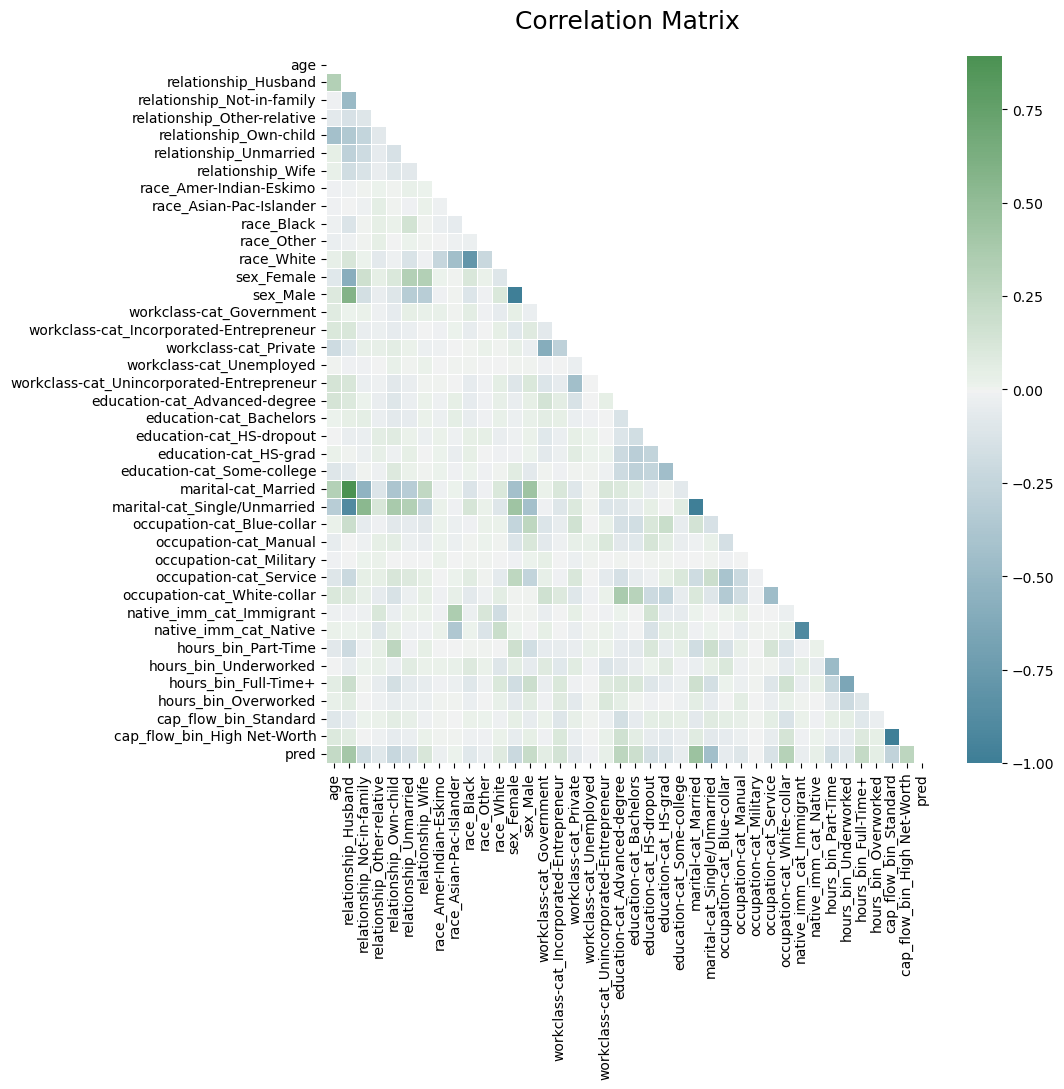

In [6]:
# --- 1. Encode categoricals, keep pred numeric ---
# (drop_first=False so every category appears)
encoded_df = pd.get_dummies(
    new_df.drop(columns=["pred"]),
    drop_first=False
)

# add target back
encoded_df["pred"] = new_df["pred"].values

# correlation matrix
corr_matrix = encoded_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(11, 11))  # put BEFORE heatmap
ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=sns.diverging_palette(225, 130, as_cmap=True),
    linewidths=0.5,
    center=0
)

ax.set_title("Correlation Matrix", fontsize=18, pad=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

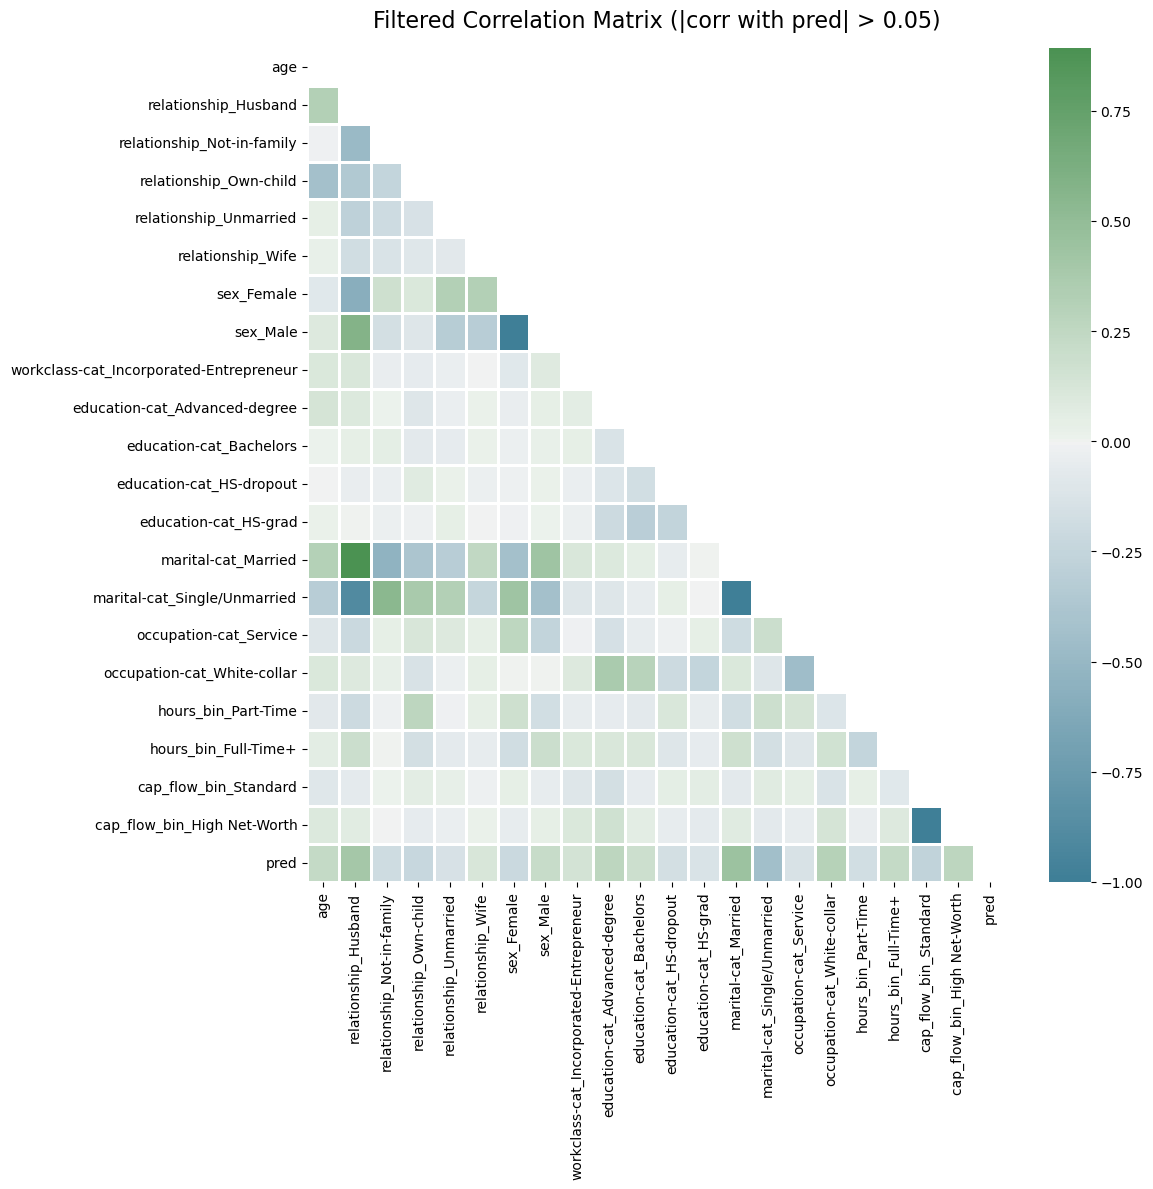

In [7]:
# absolute correlation with target
target_corr = corr_matrix["pred"].abs()

# choose "important" columns
important_cols = target_corr[target_corr > 0.12].index

# filter matrix to those cols only
filtered_corr = corr_matrix.loc[important_cols, important_cols]

mask_filt = np.triu(np.ones_like(filtered_corr, dtype=bool))

plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    filtered_corr,
    mask=mask_filt,
    cmap=sns.diverging_palette(225, 130, as_cmap=True),
    linewidths=1,
    center=0,
    annot=False
)

ax.set_title("Filtered Correlation Matrix (|corr with pred| > 0.05)", fontsize=16, pad=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [8]:
def plot_cat_target_heatmap(df, cat_col, target_col="pred"):
    """
    Creates a heatmap showing the correlation between each category of cat_col 
    and the target_col.
    """
    
    # 1) One-hot encode the categorical column
    dummies = pd.get_dummies(df[cat_col], prefix=cat_col, drop_first=False)

    # 2) Build a dataframe that includes the dummy columns + target
    corr_df = pd.concat([dummies, df[target_col]], axis=1)

    # 3) Compute correlations
    corr = corr_df.corr()[target_col].drop(target_col)

    corr = corr.reindex(corr.sort_values(ascending=False).index)

    # Convert to DataFrame so sns.heatmap works (needs 2D)
    corr_matrix = corr.to_frame(name="Correlation")

    # 4) Plot
    plt.figure(figsize=(6, max(4, len(corr_matrix)*0.4)))
    ax = sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".3f",
        cmap=sns.diverging_palette(225, 130, as_cmap=True),
        vmin=-1,
        vmax=1,
        cbar=True,
        linewidths=1
    )
    
    plt.title(f"Correlation of {cat_col} vs {target_col}", fontsize=14)
    #plt.xlabel("Correlation")
    plt.ylabel("Category")
    plt.tight_layout()
    plt.show()

In [9]:
def plot_cat_target_bars(df, cat_col, cat, target_col="pred"):
    """
    Creates a diverging horizontal bar chart showing the correlation between 
    each category of cat_col and the target variable.
    """

    # 1) One-hot encode category
    dummies = pd.get_dummies(df[cat_col], prefix=cat_col, drop_first=False)

    # 2) Build correlation DF with target
    corr_df = pd.concat([dummies, df[target_col]], axis=1)
    corr = corr_df.corr()[target_col].drop(target_col)

    # 3) Sort by absolute value (descending)
    corr = corr.reindex(corr.sort_values(ascending=False).index)

    # 4) Plot diverging bar chart
    plt.figure(figsize=(9, 3))

    colors = corr.apply(lambda x: '#A3C9A8' if x > 0 else "#87AFC7")

    plt.barh(
        corr.index,
        corr.values,
        color=colors
    )

    # Add vertical line at zero
    plt.axvline(0, color="black", linewidth=1)

    plt.title(f"Correlation of Categories vs Target (+/- $50K)", fontsize=14)
    plt.xlabel("Correlation")
    plt.ylabel("Category")
    plt.xlim(-0.5,0.5)

    plt.gca().invert_yaxis()  # Highest correlation on top
    plt.tight_layout()
    plt.show()

In [10]:
def plot_cat_target_bars2(df, cat_col, y_label = 'Category', target_col="pred"):
    """
    Diverging horizontal bar chart of correlation between each category of
    cat_col and the target variable.

    y-axis label  = y_label (e.g. "Education")
    y-tick labels = clean category names (e.g. "Bachelors", "HS-grad", ...)
    """
    # 1) One-hot encode the category
    dummies = pd.get_dummies(df[cat_col], prefix=cat_col, drop_first=False)

    # 2) Correlation with target
    corr_df = pd.concat([dummies, df[target_col]], axis=1)
    corr = corr_df.corr()[target_col].drop(target_col)

    # 3) Build Series of clean labels (indexed by dummy column name)
    clean_labels = pd.Series(
        corr.index.str.replace(f"{cat_col}_", "", regex=False),
        index=corr.index
    )

    # 4) Sort correlations (strongest positive first; change if you prefer abs)
    corr_sorted = corr.sort_values(ascending=False)
    clean_labels_sorted = clean_labels.loc[corr_sorted.index]

    # 5) Colors (green for +, blue-gray for −)
    colors = corr_sorted.apply(lambda x: "#A3C9A8" if x > 0 else "#87AFC7")

    # 6) Positions for bars
    y_pos = np.arange(len(corr_sorted))

    plt.figure(figsize=(9, 3))

    # Bars
    plt.barh(y_pos, corr_sorted.values, color=colors)

    # y-tick labels = clean category names
    plt.yticks(y_pos, clean_labels_sorted.values)

    # Zero line
    plt.axvline(0, color="black", linewidth=1)

    # Annotate values on bars


    plt.title("Correlation of Categories vs Target (+/- $50K)", fontsize=14)
    plt.xlabel("Correlation")
    plt.ylabel(y_label)
    plt.xlim(-0.5, 0.5)

    plt.tight_layout()
    plt.show()


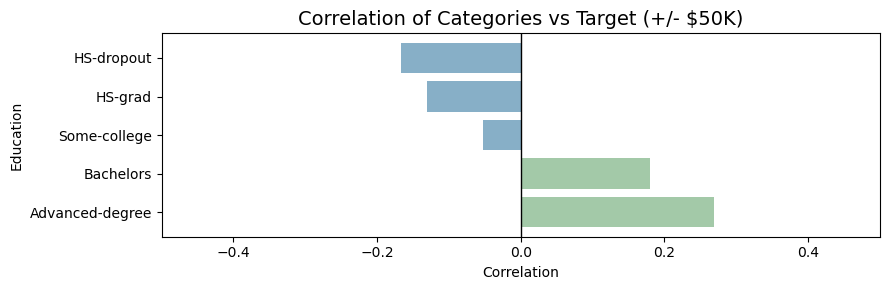

In [11]:
plot_cat_target_bars2(new_df, 'education-cat', 'Education')

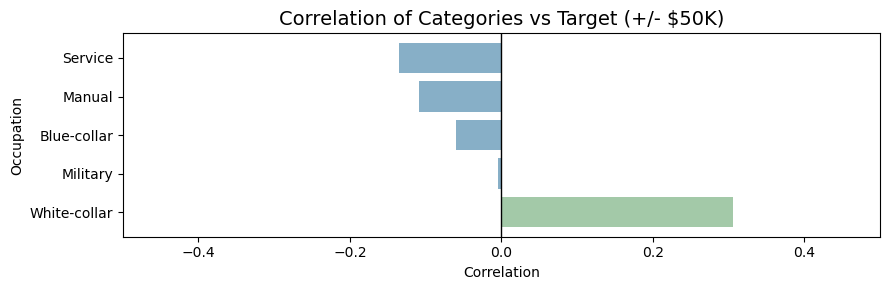

In [12]:
plot_cat_target_bars2(new_df, 'occupation-cat', 'Occupation')

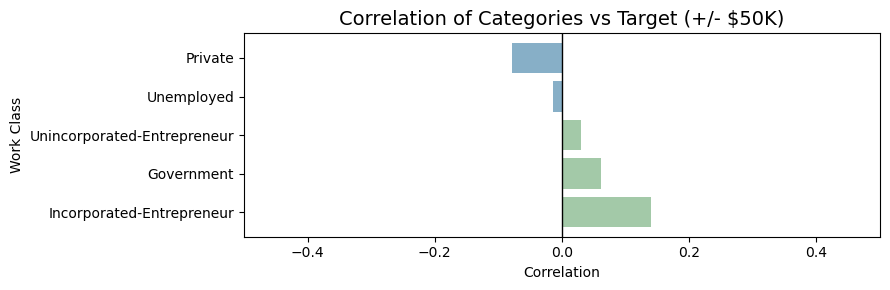

In [13]:
plot_cat_target_bars2(new_df, 'workclass-cat', 'Work Class')

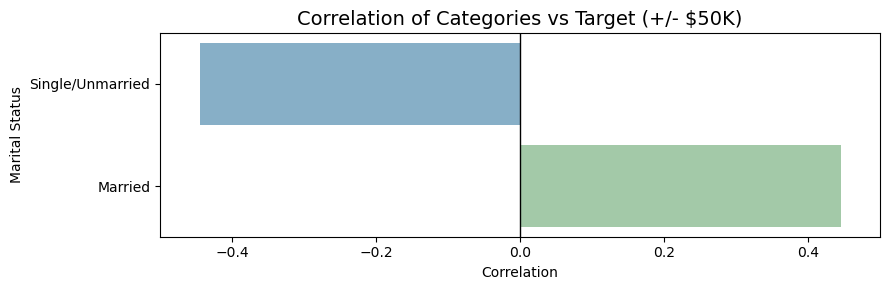

In [14]:
plot_cat_target_bars2(new_df, 'marital-cat', 'Marital Status')

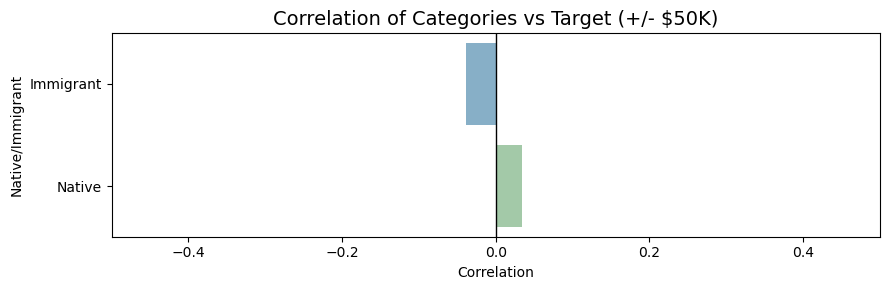

In [15]:
plot_cat_target_bars2(new_df, 'native_imm_cat', 'Native/Immigrant')

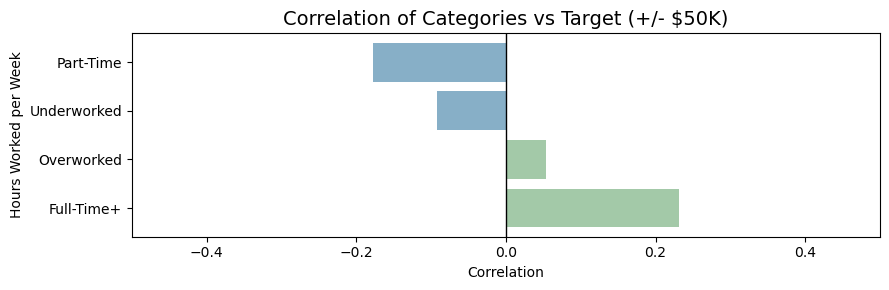

In [16]:
plot_cat_target_bars2(new_df, 'hours_bin', 'Hours Worked per Week')

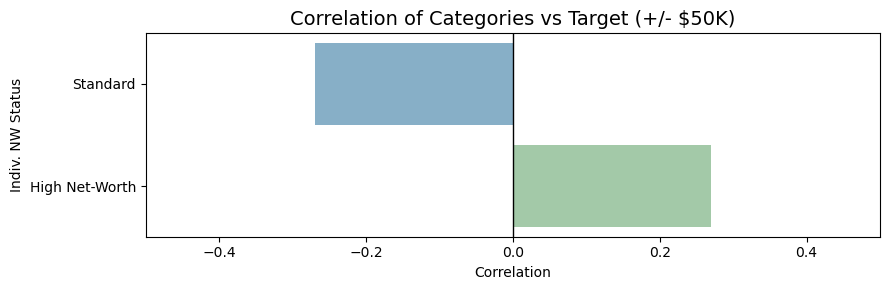

In [17]:
plot_cat_target_bars2(new_df, 'cap_flow_bin', 'Indiv. NW Status')

In [18]:
train_df_drop = train_df.copy()

train_df_drop = data_to_str(train_df_drop)
train_df_drop = replace_qmarks(train_df_drop)

### Train Test Split

In [19]:
target_col = "pred"

X_train_raw = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test_raw  = test_df.drop(columns=[target_col])
y_test  = test_df[target_col]

X_train_drop_raw = train_df_drop.drop(columns=[target_col])

## Testing Imbalanced Approaches for RFC

In [20]:
numeric_features = ["age"]

categorical_features = [
    "relationship", "race", "sex",
    "workclass-cat", "education-cat", "marital-cat",
    "occupation-cat", "native_imm_cat",
    "hours_bin", "cap_flow_bin"
]

numeric_transformer_rf = skPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # no scaling/log for RF
])

categorical_transformer = skPipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)


In [21]:
# Base RF settings (same for both)
rf_common_kwargs = dict(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)


# 1) RF + balanced_subsample
rf_balanced = RandomForestClassifier(
    class_weight="balanced_subsample",
    **rf_common_kwargs
)

rf_balanced_pipe = ImbPipeline(steps=[
    ("prep", BasicPrep()),
    ("preprocessor", preprocessor_rf),
    ("sampler", "passthrough"),
    ("clf", rf_balanced),
])

# 2) RF + no rebalancing
rf_plain = RandomForestClassifier(
    class_weight=None,   # <-- important: no balancing
    **rf_common_kwargs
)

rf_plain_pipe = ImbPipeline(steps=[
    ("prep", BasicPrep()),         # cleaning + remapping
    ("preprocessor", preprocessor_rf),
    ("sampler", "passthrough"),    # no oversampling
    ("clf", rf_plain),
])

In [22]:
print("=== RF (Plain) ===")
rf_plain_pipe.fit(X_train_raw, y_train)
y_pred_plain = rf_plain_pipe.predict(X_test_raw)
print(classification_report(y_test, y_pred_plain))

print("\n=== RF + balanced_subsample ===")
rf_balanced_pipe.fit(X_train_raw, y_train)
y_pred_bal = rf_balanced_pipe.predict(X_test_raw)
print(classification_report(y_test, y_pred_bal))

=== RF (Plain) ===
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     12435
           1       0.70      0.57      0.63      3846

    accuracy                           0.84     16281
   macro avg       0.79      0.75      0.77     16281
weighted avg       0.83      0.84      0.84     16281


=== RF + balanced_subsample ===
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     12435
           1       0.57      0.80      0.67      3846

    accuracy                           0.81     16281
   macro avg       0.75      0.81      0.77     16281
weighted avg       0.84      0.81      0.82     16281



/Users/johnchester/Desktop/homework/env/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


# Logistic Regression
## Build transformers, identify features

In [23]:
numeric_features = ["age"]

categorical_features = [
    "relationship", "race", "sex",
    "workclass-cat", "education-cat", "marital-cat",
    "occupation-cat", "native_imm_cat",
    "hours_bin", "cap_flow_bin"
]

# Numeric pipeline
numeric_transformer = skPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", MinMaxScaler())
])

# Categorical pipeline
categorical_transformer = skPipeline(steps=[
    ("imputer", SimpleImputer(
        strategy="most_frequent",   # or "constant" with fill_value="Unknown"
        fill_value="Unknown"
    )),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

## Build pipeline & test using GridSearchCV

In [24]:
logreg_base = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    solver="lbfgs",
    penalty="l2"
)

logreg_pipeline = ImbPipeline(steps=[
    ("prep", BasicPrep()),
    ("preprocessor", preprocessor),
    ("sampler", "passthrough"),  # will be set to ROS or passthrough in grid
    ("clf", logreg_base),
])

logreg_param_grid = {
    # --- categorical missing-data ---
    "preprocessor__cat__imputer__strategy": ["most_frequent", "constant"],
    # "constant" uses fill_value="Unknown" already set above

    # --- numeric normalization on age ---
    "preprocessor__num__log": [
        "passthrough",
        FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    ],
    "preprocessor__num__scaler": [
        "passthrough",
        MinMaxScaler(),
    ],

    # --- imbalance handling ---
    "sampler": [
        "passthrough",
        RandomOverSampler(random_state=42),
    ],

    # --- LogisticRegression hyperparams ---
    "clf__C": [0.1, 1.0, 10.0],
}

logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=logreg_param_grid,
    cv=5,
    scoring="accuracy",  # or 'f1_macro'
    n_jobs=-1,
    verbose=1
)

logreg_grid.fit(X_train_raw, y_train)

print("Best params (LogReg):", logreg_grid.best_params_)
print("Best CV accuracy (LogReg):", logreg_grid.best_score_)

print("Test accuracy (LogReg):", logreg_grid.score(X_test_raw, y_test))
print(classification_report(y_test, logreg_grid.predict(X_test_raw)))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params (LogReg): {'clf__C': 10.0, 'preprocessor__cat__imputer__strategy': 'constant', 'preprocessor__num__log': FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>), 'preprocessor__num__scaler': MinMaxScaler(), 'sampler': 'passthrough'}
Best CV accuracy (LogReg): 0.8424496310723857
Test accuracy (LogReg): 0.8436828204655734
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12435
           1       0.71      0.57      0.63      3846

    accuracy                           0.84     16281
   macro avg       0.79      0.75      0.77     16281
weighted avg       0.84      0.84      0.84     16281



In [25]:
from sklearn.linear_model import LogisticRegression

lr_base = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    solver="lbfgs",
    penalty="l2",
    class_weight=None   # we’ll let bagging do the balancing
)

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

bb_logreg = BalancedBaggingClassifier(
    estimator=lr_base,
    n_estimators=25,          # you can bump to 50+ if runtime is OK
    sampling_strategy="auto", # balance the classes in each bag
    replacement=True,         # bootstrap sampling
    random_state=42,
    n_jobs=-1
)

bb_logreg_pipe = ImbPipeline(steps=[
    ("prep", BasicPrep()),     # your cleaner + remapper
    ("preprocessor", preprocessor),
    ("clf", bb_logreg),
])


In [26]:
X_train_raw = train_df.drop(columns=["pred"])
y_train     = train_df["pred"]
X_test_raw  = test_df.drop(columns=["pred"])
y_test = test_df["pred"]

from sklearn.metrics import classification_report

print("=== Balanced Bagging + Logistic Regression ===")
bb_logreg_pipe.fit(X_train_raw, y_train)
y_pred_bb = bb_logreg_pipe.predict(X_test_raw)
print(classification_report(y_test, y_pred_bb))


=== Balanced Bagging + Logistic Regression ===
              precision    recall  f1-score   support

           0       0.94      0.78      0.85     12435
           1       0.55      0.85      0.66      3846

    accuracy                           0.80     16281
   macro avg       0.74      0.81      0.76     16281
weighted avg       0.85      0.80      0.81     16281



### LogReg GridSearch for Bagging

In [27]:
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# ----- Bagged Logistic Regression base setup -----
lr_base = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    solver="lbfgs",
    penalty="l2"
)

bb_logreg = BalancedBaggingClassifier(
    estimator=lr_base,
    n_estimators=50,          # will be tuned
    sampling_strategy="auto", # class balancing per bag
    replacement=True,
    random_state=42,
    n_jobs=-1
)

bb_logreg_pipe = ImbPipeline(steps=[
    ("prep", BasicPrep()),     # your cleaning + remapping
    ("preprocessor", preprocessor),  # log + MinMax + OHE
    ("clf", bb_logreg)
])

# ----- Hyperparameter grid for Bagged LogReg -----
lr_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__estimator__C": [0.1, 1.0, 10.0],         # LR regularization
    "clf__estimator__class_weight": [None, "balanced"]
}

lr_grid = GridSearchCV(
    estimator=bb_logreg_pipe,
    param_grid=lr_param_grid,
    cv=5,
    scoring="f1_macro",  # or 'accuracy'
    n_jobs=-1,
    verbose=1
)

# ----- Fit + evaluate -----
lr_grid.fit(X_train_raw, y_train)

print("Best params (Bagged LogReg):", lr_grid.best_params_)
print("Best CV score (Bagged LogReg):", lr_grid.best_score_)

y_pred_lr = lr_grid.predict(X_test_raw)
print("\n=== Test performance: Bagged LogReg ===")
print(classification_report(y_test, y_pred_lr))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

### GridSearch for DecTree Bagging

In [ ]:
# ----- Bagged Decision Tree base setup -----
base_tree = DecisionTreeClassifier(
    random_state=42
)

bb_tree = BalancedBaggingClassifier(
    estimator=base_tree,
    n_estimators=25,          # will be tuned
    sampling_strategy="auto", # balance classes in each bag
    replacement=True,
    random_state=42,
    n_jobs=-1
)

dt_bag_pipe = ImbPipeline(steps=[
    ("prep", BasicPrep()),     # your cleaning + remapping
    ("preprocessor", preprocessor_rf),
    ("clf", bb_tree)
])

# ----- Hyperparameter grid for Bagged DT -----
dt_param_grid = {
    "clf__n_estimators": [200, 400],          # size of the bagging ensemble
    "clf__estimator__max_depth": [None, 10, 20],
    "clf__estimator__min_samples_leaf": [1, 2, 5]
}

dt_grid = GridSearchCV(
    estimator=dt_bag_pipe,
    param_grid=dt_param_grid,
    cv=5,
    scoring="f1_macro",  # or "accuracy", but f1_macro is nicer for imbalance
    n_jobs=-1,
    verbose=1
)

# ----- Fit + evaluate -----
dt_grid.fit(X_train_raw, y_train)

print("Best params (Bagged DT):", dt_grid.best_params_)
print("Best CV score (Bagged DT):", dt_grid.best_score_)

y_pred_dt = dt_grid.predict(X_test_raw)
print("\n=== Test performance: Bagged DT ===")
print(classification_report(y_test, y_pred_dt))


# RandomForestClassifier
## Build transformers

In [ ]:
numeric_transformer_rf = skPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
    # no log, no scaler – RF is tree-based and scale-invariant
])

preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

## Build pipeline & test using GridSearchCV

In [ ]:
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

rf_pipeline = ImbPipeline(steps=[
    ("prep", BasicPrep()),
    ("preprocessor", preprocessor_rf),
    ("sampler", "passthrough"),
    ("clf", rf_base)
])

rf_param_grid = {
    # cat missing data
    "preprocessor__cat__imputer__strategy": ["most_frequent", "constant"],

    # imbalance handling
    "sampler": [
        "passthrough",
        RandomOverSampler(random_state=42)
    ],

    # RF hyperparams – trimmed
    "clf__n_estimators": [100, 200],       # 400 is overkill for a grid
    "clf__max_depth": [None, 20],          # drop the 10
    "clf__min_samples_leaf": [1, 2]      # drop the 5
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_raw, y_train)

print("Best params (RF):", rf_grid.best_params_)
print("Best CV accuracy (RF):", rf_grid.best_score_)

print("Test accuracy (RF):", rf_grid.score(X_test_raw, y_test))
print(classification_report(y_test, rf_grid.predict(X_test_raw)))

### Dropped Missing Data DF

In [ ]:
rf_param_grid = {
    # cat missing data
    #"preprocessor__cat__imputer__strategy": ["most_frequent", "constant"],

    # imbalance handling
    "sampler": [
        "passthrough",
        RandomOverSampler(random_state=42)
    ],

    # RF hyperparams – trimmed
    "clf__n_estimators": [200, 400],       # 400 is overkill for a grid
    "clf__max_depth": [20],          # drop the 10
    "clf__min_samples_leaf": [2]       # drop the 5
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_drop_raw, y_train)

print("Best params (RF):", rf_grid.best_params_)
print("Best CV accuracy (RF):", rf_grid.best_score_)

print("Test accuracy (RF):", rf_grid.score(X_test_raw, y_test))
print(classification_report(y_test, rf_grid.predict(X_test_raw)))

## Forest Bagging

In [ ]:
# Base tree for each bag
base_tree = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=2,
    random_state=42
)

bb_clf = BalancedBaggingClassifier(
    estimator=base_tree,           # base estimator in each bag
    n_estimators=100,               # number of bags (ensemble size)
    sampling_strategy="auto",      # balance minority/majority automatically
    replacement=True,              # bootstrap sampling
    random_state=42,
    n_jobs=-1
)

bb_pipe = ImbPipeline(steps=[
    ("prep", BasicPrep()),         # your cleaning + remapping
    ("preprocessor", preprocessor_rf),
    ("clf", bb_clf),
])


In [ ]:
models = {
    "RF_plain": rf_plain_pipe,
    "RF_balanced_subsample": rf_balanced_pipe,
    "BalancedBagging_DT": bb_pipe
}

for name, pipe in models.items():
    print(f"\n=== {name} ===")
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    print(classification_report(y_test, y_pred))
